/home/vscode/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                Model  Dimensions  Size (MB)  Load Time (s)  Encoding Time (s)  Total Time (s)  Similar Pair Similarity  Different Pair Similarity  Contrast
                     all-MiniLM-L6-v2         384  86.644043       0.652831           0.165005        0.818576                 0.537720                   0.054547  0.483173
                    all-MiniLM-L12-v2         384 127.258301       1.403130           0.051881        1.455721                 0.600507                   0.175118  0.425388
                    all-mpnet-base-v2         768 417.657715      11.880691           0.274659       12.156087                 0.659811                   0.036776  0.623036
paraphrase-multilingual-MiniLM-L12-v2         384 448.813477       3.386972           0.064756        3.452784                 0.513916                   0.154445  0.359471


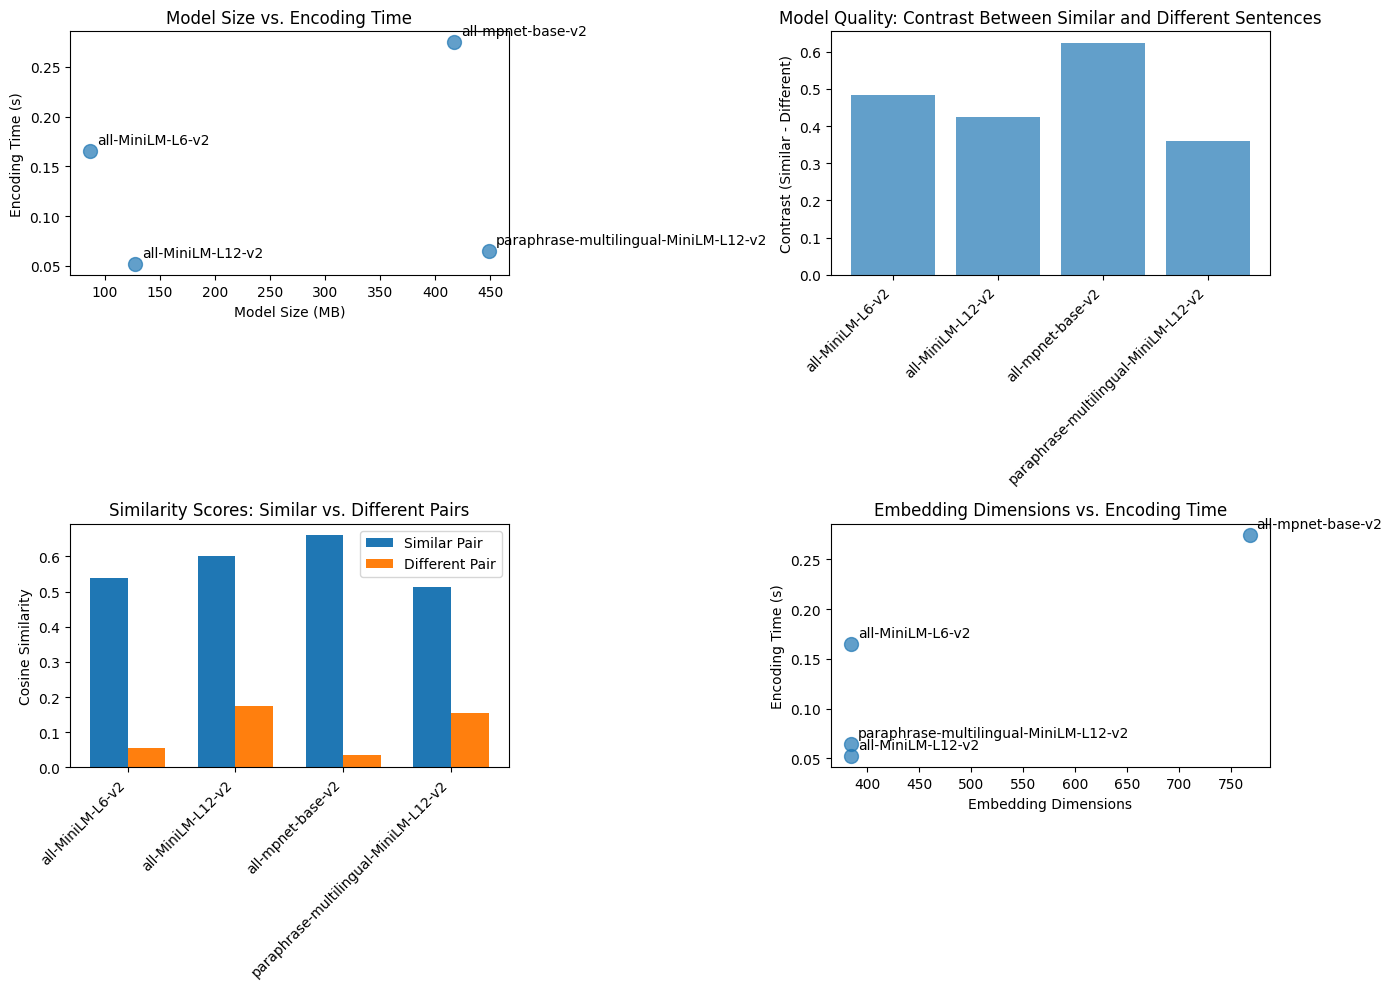


Production Deployment Considerations:
1. Small models (like all-MiniLM-L6-v2) are suitable for high-throughput applications
2. Larger models provide better semantic accuracy but require more resources
3. Multilingual models add versatility but may sacrifice some performance for specific languages
4. Consider batching and GPU acceleration for production deployments
5. Dimension reduction techniques can be applied to large embeddings if storage is a concern


In [1]:
from sentence_transformers import SentenceTransformer, util
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define models to compare - ranging from small and fast to large and accurate
models = [
    'all-MiniLM-L6-v2',        # Small model (384d)
    'all-MiniLM-L12-v2',       # Medium model (384d)
    'all-mpnet-base-v2',       # Large model (768d)
    'paraphrase-multilingual-MiniLM-L12-v2'  # Multilingual model (384d)
]

# Example sentences for benchmarking
sentences = [
    "Machine learning models require significant computational resources.",
    "AI systems need a lot of computing power to train.",
    "The weather forecast predicts rain for tomorrow.",
    "I need to get a new computer for my office.",
    "What's the best algorithm for text classification?",
    "How can I optimize my neural network training time?"
]

# Create dataframe to store comparison results
results = []

for model_name in models:
    start_time = time.time()

    # Load model
    model_load_time = time.time()
    model = SentenceTransformer(model_name)
    model_load_time = time.time() - model_load_time

    # Encode sentences
    encoding_time = time.time()
    embeddings = model.encode(sentences)
    encoding_time = time.time() - encoding_time

    # Calculate embedding dimensionality
    dim = embeddings.shape[1]

    # Get model size (parameters)
    model_size_mb = sum(p.numel() for p in model.parameters()
                        ) * 4 / 1024 / 1024  # Approx size in MB

    # Calculate similarity between sentences 0 and 1 (semantically similar)
    sim_similar = util.cos_sim(embeddings[0:1], embeddings[1:2]).item()

    # Calculate similarity between sentences 0 and 2 (semantically different)
    sim_different = util.cos_sim(embeddings[0:1], embeddings[2:3]).item()

    # Contrast: difference between similar and different pairs
    contrast = sim_similar - sim_different

    total_time = time.time() - start_time

    # Store results
    results.append({
        'Model': model_name,
        'Dimensions': dim,
        'Size (MB)': model_size_mb,
        'Load Time (s)': model_load_time,
        'Encoding Time (s)': encoding_time,
        'Total Time (s)': total_time,
        'Similar Pair Similarity': sim_similar,
        'Different Pair Similarity': sim_different,
        'Contrast': contrast
    })

# Convert to DataFrame and display
df = pd.DataFrame(results)
print(df.to_string(index=False))

# Visualize model comparison
plt.figure(figsize=(14, 10))

# Plot 1: Model size vs. Encoding time
plt.subplot(2, 2, 1)
plt.scatter(df['Size (MB)'], df['Encoding Time (s)'], s=100, alpha=0.7)
for i, model in enumerate(df['Model']):
    plt.annotate(model, (df['Size (MB)'].iloc[i], df['Encoding Time (s)'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel('Model Size (MB)')
plt.ylabel('Encoding Time (s)')
plt.title('Model Size vs. Encoding Time')

# Plot 2: Model comparison - Contrast
plt.subplot(2, 2, 2)
bars = plt.bar(df['Model'], df['Contrast'], alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Contrast (Similar - Different)')
plt.title('Model Quality: Contrast Between Similar and Different Sentences')

# Plot 3: Similar vs. Different similarity scores
plt.subplot(2, 2, 3)
x = np.arange(len(df['Model']))
width = 0.35
plt.bar(x - width/2, df['Similar Pair Similarity'],
        width, label='Similar Pair')
plt.bar(x + width/2, df['Different Pair Similarity'],
        width, label='Different Pair')
plt.xticks(x, df['Model'], rotation=45, ha='right')
plt.ylabel('Cosine Similarity')
plt.title('Similarity Scores: Similar vs. Different Pairs')
plt.legend()

# Plot 4: Encoding time vs. number of dimensions
plt.subplot(2, 2, 4)
plt.scatter(df['Dimensions'], df['Encoding Time (s)'], s=100, alpha=0.7)
for i, model in enumerate(df['Model']):
    plt.annotate(model, (df['Dimensions'].iloc[i], df['Encoding Time (s)'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Encoding Time (s)')
plt.title('Embedding Dimensions vs. Encoding Time')

plt.tight_layout()
plt.show()

# Production considerations
print("\nProduction Deployment Considerations:")
print("1. Small models (like all-MiniLM-L6-v2) are suitable for high-throughput applications")
print("2. Larger models provide better semantic accuracy but require more resources")
print("3. Multilingual models add versatility but may sacrifice some performance for specific languages")
print("4. Consider batching and GPU acceleration for production deployments")
print("5. Dimension reduction techniques can be applied to large embeddings if storage is a concern")